In [3]:
import os
import sys
from tqdm.notebook import tqdm
import numpy as np
import csv
import pickle
import json

from multiprocessing import Pool

sys.path.append('/usr/local/Cellar/graph-tool/2.35/lib/python3.8/site-packages/')
import graph_tool.all as gt

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from matplotlib.animation import FuncAnimation
%matplotlib inline

/usr/local/Cellar/graph-tool/2.35/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/local/Cellar/graph-tool/2.35/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/local/Cellar/graph-tool/2.35/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/local/Cellar/graph-tool/2.35/lib/python3.8/site-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [4]:
DUMP_LANG = 'en'
DUMP_DATE = '20200901'
RESULTS_DIR = '../results/'
graph_file = RESULTS_DIR + f"{DUMP_LANG}wiki-{DUMP_DATE}-graph.gt"
betweenness_file = RESULTS_DIR + f"{DUMP_LANG}wiki-{DUMP_DATE}-graph-betweenness.pkl"

In [5]:
graph = gt.load_graph(graph_file)
id_index_map = np.zeros((np.max(graph.vp.id.a)+1,), 'int')
id_index_map[graph.vp.id.a] = graph.get_vertices()


In [6]:
graph.num_vertices()

6148503

In [7]:
title_index_map = {}
for v in tqdm(graph.vertices()): title_index_map[graph.vp.title[v]] = v

In [8]:
largest_component_filter = gt.label_largest_component(graph)
lc_graph = gt.GraphView(graph, largest_component_filter)


In [9]:
lc_graph.num_vertices()

5548826

## Analysis

In [10]:
plt.style.use('fivethirtyeight')

### Furthest away pages

In [11]:
d,e = gt.pseudo_diameter(graph, np.random.choice(list(graph.vertices())))
print(d)
print(list(map(lambda v: graph.vp.title[v], e)))

68.0
['The Near Future (film)', '1930 São Paulo FC season']


In [12]:
source = 'United States'

dist, pred = gt.shortest_distance(lc_graph, title_index_map[source], pred_map=True)
for v in np.argsort(dist.a)[::-1]:
    if dist[v] < 10: break
    print(dist[v], lc_graph.vp.title[v])

67 1930 São Paulo FC season
66 1931 São Paulo FC season
65 1932 São Paulo FC season
64 1933 São Paulo FC season
63 1934 São Paulo FC season
62 1935 São Paulo FC season
61 1936 São Paulo FC season
60 1937 São Paulo FC season
59 1938 São Paulo FC season
58 1939 São Paulo FC season
57 1940 São Paulo FC season
56 1941 São Paulo FC season
55 1942 São Paulo FC season
54 1943 São Paulo FC season
53 1944 São Paulo FC season
52 1945 São Paulo FC season
51 1946 São Paulo FC season
50 1947 São Paulo FC season
49 1948 São Paulo FC season
48 1949 São Paulo FC season
47 1950 São Paulo FC season
46 1951 São Paulo FC season
46 1948–49 FC Dinamo București season
45 1952 São Paulo FC season
45 1950 FC Dinamo București season
44 1968 Liga Deportiva Universitaria de Quito season
44 1953 São Paulo FC season
44 1951 FC Dinamo București season
43 1954 São Paulo FC season
43 1969 Liga Deportiva Universitaria de Quito season
43 1952 FC Dinamo București season
42 1955 São Paulo FC season
42 Papyrus Oxyrhynchus 

11 Rotta, Germany
11 1900–01 Cornell men's ice hockey season
11 Results breakdown of the 1995 Spanish local elections (Castilla–La Mancha)
11 An Experiment in Treason
11 USS Vencedor (SP-669)
11 Amphipneustes koehleri
11 Straszyn Prędzieszyn railway station
11 List of 1992 Seattle Mariners draft picks
11 Frosti Jonsson
11 Franklin B. Jenkins House (Middle Street, Stoneham, Massachusetts)
11 László Ur
11 Berwig Halt railway station
11 Daniel Lysacht
11 1998–99 Trabzonspor season
11 1670 in Sweden
11 1965 in Portugal
11 1973–74 Clydebank F.C. season
11 Third Sturdza cabinet
11 Collett (name)
11 Results breakdown of the 1995 Spanish local elections (Community of Madrid)
11 1961–62 Dundee United F.C. season
11 2019 in birding and ornithology
11 Kraków Peninsula
11 Misia Candle Night 2015
11 Dahlberg, Florida
11 Les Owen
11 1980–81 VfL Bochum season
11 1978–79 Clydebank F.C. season
11 George Pilkington (footballer, born 1926)
11 Coon Creek (South Fork Fabius River tributary)
11 1986 São Pau

### Histogram of distances

In [40]:

sources = np.random.choice(list(lc_graph.vertices()), 1000, replace=False)

def get_dists(source):
    return gt.shortest_distance(lc_graph, source).a[lc_graph.get_vertices()]

dist = np.concatenate(list(map(get_dists, tqdm(sources))))
u, ucount = np.unique(dist,return_counts=True)
ufreq = ucount / np.sum(ucount)

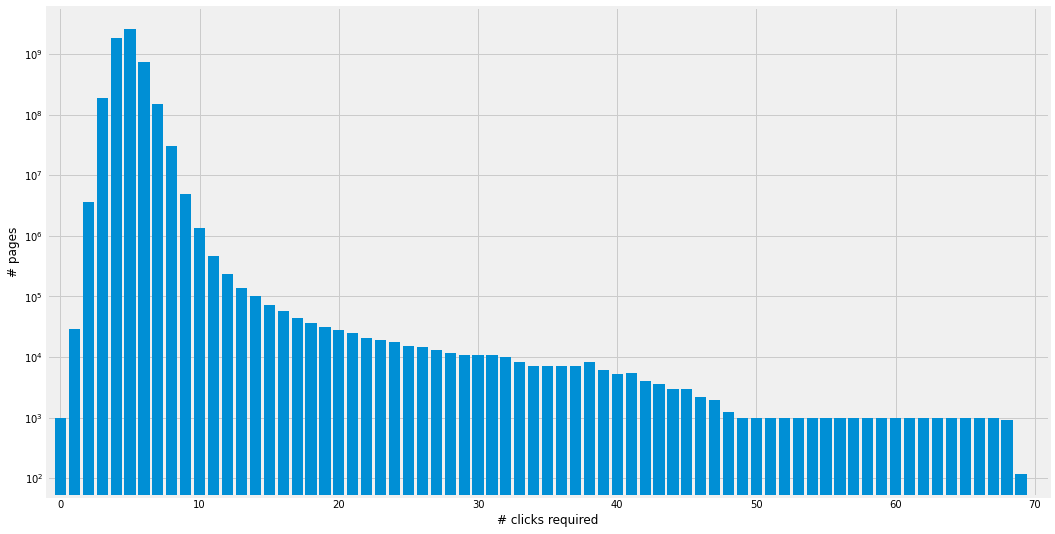

In [41]:
fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('white')

ax.bar(u, ucount)
ax.set_xlim(-1,71)
ax.set_xlabel('# clicks required')
ax.set_yscale('log')
ax.set_ylabel('# pages')
ax.label_outer()

plt.show()

In [29]:
with open(RESULTS_DIR + f"{DUMP_LANG}wiki-{DUMP_DATE}-path-length-frequency.json", "w") as f:
    json.dump([{"x": int(i[0]), "y": i[1]} for i in zip(u,ufreq)], f)

In [42]:
np.cumsum(ufreq)

array([1.80218302e-07, 5.41537976e-06, 6.69833042e-04, 3.52229311e-02,
       3.68884719e-01, 8.32537816e-01, 9.66550935e-01, 9.93190187e-01,
       9.98610815e-01, 9.99483639e-01, 9.99729626e-01, 9.99814862e-01,
       9.99857414e-01, 9.99882376e-01, 9.99900679e-01, 9.99913799e-01,
       9.99924214e-01, 9.99932212e-01, 9.99938700e-01, 9.99944375e-01,
       9.99949505e-01, 9.99953969e-01, 9.99957672e-01, 9.99961159e-01,
       9.99964389e-01, 9.99967113e-01, 9.99969717e-01, 9.99972041e-01,
       9.99974108e-01, 9.99976091e-01, 9.99978073e-01, 9.99980013e-01,
       9.99981808e-01, 9.99983276e-01, 9.99984540e-01, 9.99985802e-01,
       9.99987106e-01, 9.99988412e-01, 9.99989912e-01, 9.99991032e-01,
       9.99991973e-01, 9.99992973e-01, 9.99993706e-01, 9.99994345e-01,
       9.99994887e-01, 9.99995417e-01, 9.99995812e-01, 9.99996164e-01,
       9.99996390e-01, 9.99996571e-01, 9.99996751e-01, 9.99996931e-01,
       9.99997111e-01, 9.99997292e-01, 9.99997472e-01, 9.99997652e-01,
      

In [13]:
ucount

array([      10,      406,    44612,  2288048, 20232297, 22860260,
        7929600,  1756003,   296493,    50602,    14523,     5087,
           2357,     1433,     1022,      726,      568,      448,
            364,      317,      280,      246,      207,      193,
            176,      154,      146,      130,      114,      111,
            110,      106,      100,       78,       71,       70,
             72,       74,       85,       61,       53,       53,
             42,       35,       30,       30,       22,       20,
             13,       11,       10,       10,       10,       10,
             10,       10,       10,       10,       10,       10,
             10,       10,       10,       10,       10,       10,
             10,       10,       10,        1])

### Shortest path

In [25]:

target = '1930 São Paulo FC season'
source = 'No Guru, No Method, No Teacher'
print(title_index_map[source])
print(title_index_map[target])
path, _ = gt.shortest_path(graph, title_index_map[source], title_index_map[target])
print([graph.vp.title[v] for v in path])

1427570
4801704
['No Guru, No Method, No Teacher', 'England', 'England national football team', '2006 FIFA World Cup squads', 'Rogério Ceni', '1993 São Paulo FC season', '1992 São Paulo FC season', '1991 São Paulo FC season', '1990 São Paulo FC season', '1989 São Paulo FC season', '1988 São Paulo FC season', '1987 São Paulo FC season', '1986 São Paulo FC season', '1985 São Paulo FC season', '1984 São Paulo FC season', '1983 São Paulo FC season', '1982 São Paulo FC season', '1981 São Paulo FC season', '1980 São Paulo FC season', '1979 São Paulo FC season', '1978 São Paulo FC season', '1977 São Paulo FC season', '1976 São Paulo FC season', '1975 São Paulo FC season', '1974 São Paulo FC season', '1973 São Paulo FC season', '1972 São Paulo FC season', '1971 São Paulo FC season', '1970 São Paulo FC season', '1969 São Paulo FC season', '1968 São Paulo FC season', '1967 São Paulo FC season', '1966 São Paulo FC season', '1965 São Paulo FC season', '1964 São Paulo FC season', '1963 São Paulo FC

### Histogram of vertex degrees

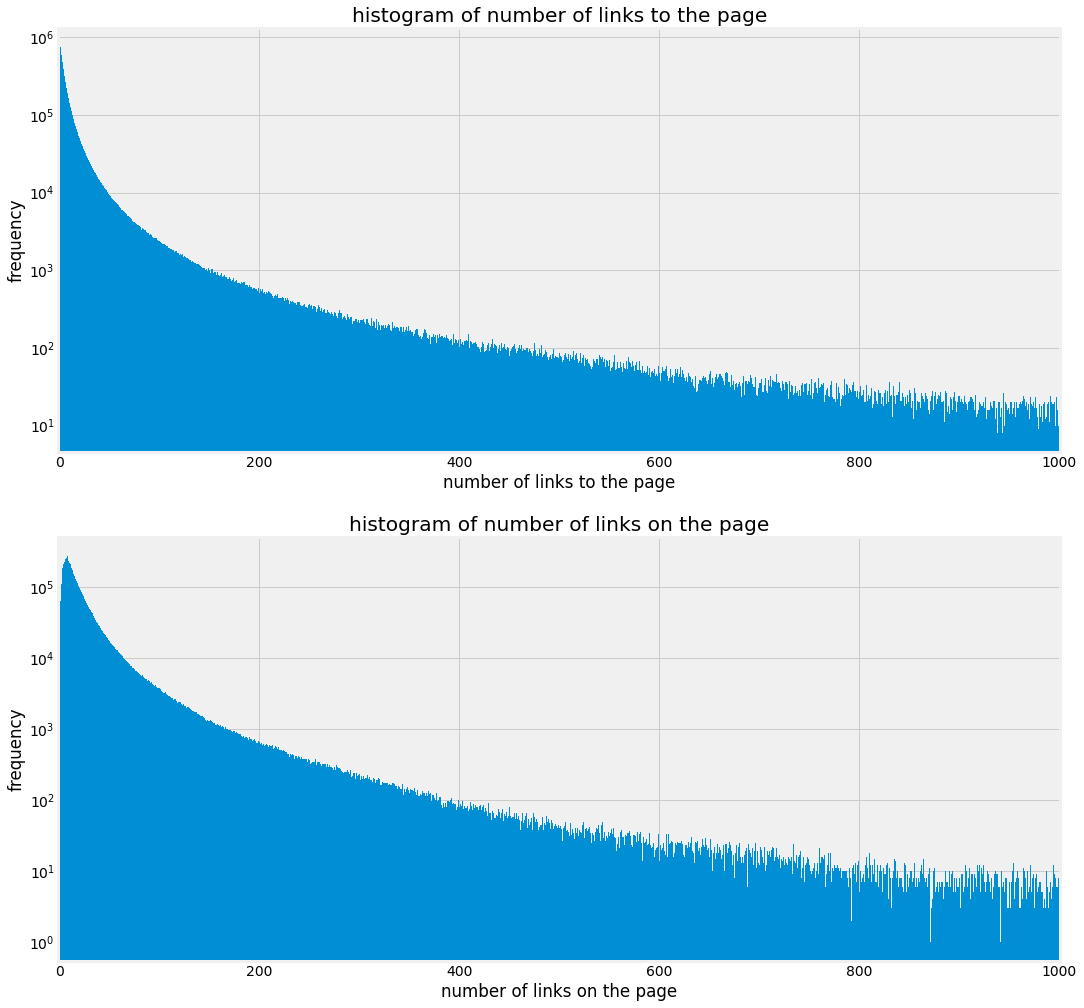

In [13]:
fig, axs = plt.subplots(2,figsize=(16,16))
fig.patch.set_facecolor('white')

lim = 1000

hist_type = ['number of links to the page','number of links on the page']

for (i,d) in enumerate(['in','out']):
    hist = gt.vertex_hist(lc_graph, d)[0]
    
    ax = axs.flat[i]
    ax.bar(np.arange(lim), hist[:lim])
    ax.set_title('histogram of ' + hist_type[i])
    ax.set_xlim(-1,lim+1)
    ax.set_xlabel(hist_type[i])
    ax.set_yscale('log')
    ax.set_ylabel('frequency')
#     ax.label_outer()

plt.show()


### Comparison of connectivity w/ and w/o countries

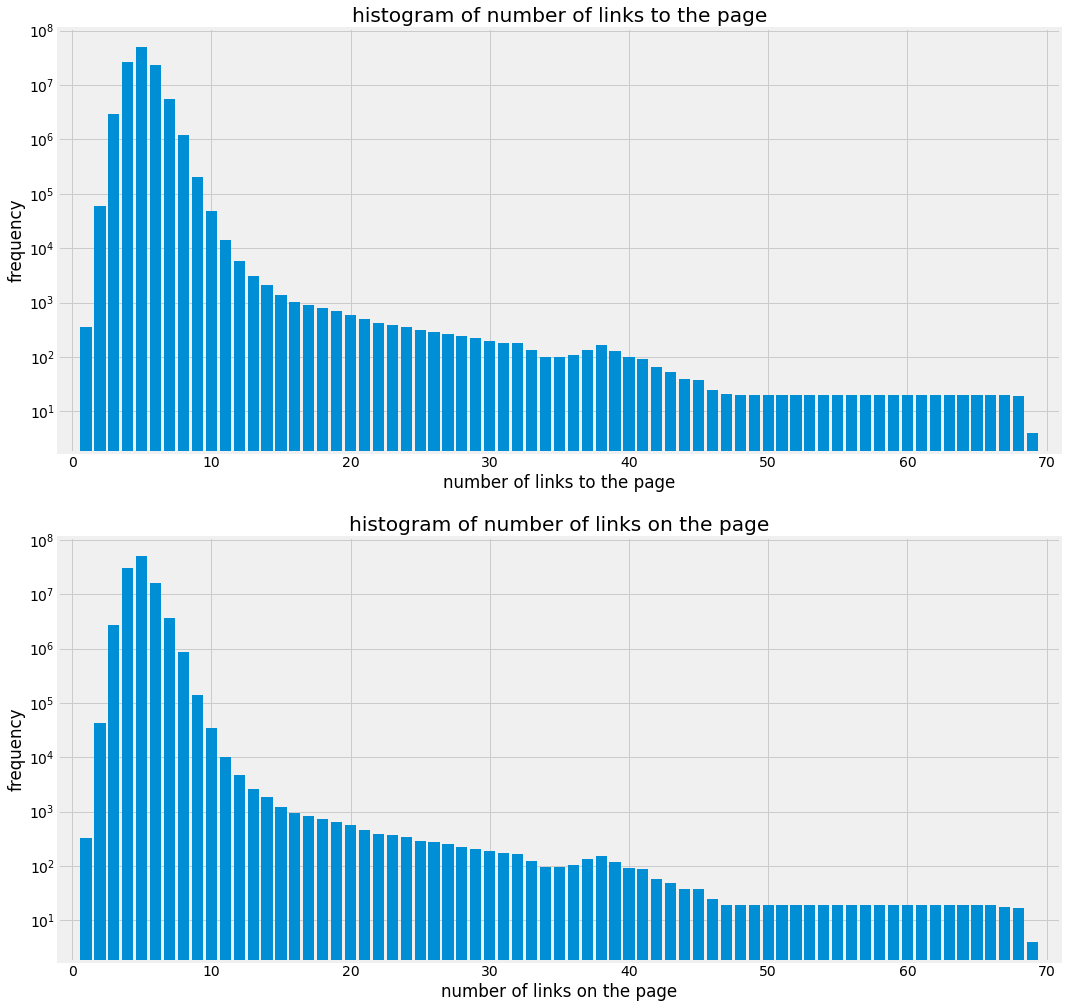

In [15]:
fig, axs = plt.subplots(2,figsize=(16,16))
fig.patch.set_facecolor('white')

hist_type = ['number of links to the page','number of links on the page']

cfilter = lc_graph.new_vp('bool',val=True)
with open('resources/country-codes.pkl', 'rb') as f:
    d = pickle.load(f)
    for i in d:
        if d[i] in title_index_map: cfilter[title_index_map[d[i]]] = False

for i in range(2):
    lc_graph.set_vertex_filter([None,cfilter][i])
    hist = gt.distance_histogram(graph, samples=20)[0]
    lc_graph.clear_filters()
    
    ax = axs.flat[i]
    ax.bar(np.arange(hist.size), hist)
    ax.set_title('histogram of ' + hist_type[i])
    ax.set_xlabel(hist_type[i])
    ax.set_xlim(-1,71)
    ax.set_yscale('log')
    ax.set_ylabel('frequency')
#     ax.label_outer()

plt.show()


### Remove most central nodes from the graph

In [39]:
load_from_file = False

if load_from_file:
    with open(betweenness_file, 'rb') as f:
        vb_map = pickle.load(f)
else:
    vb_map = gt.betweenness(lc_graph, np.random.choice(lc_graph.get_vertices(), 100, replace=False))[0]
    vb_map.a[np.setdiff1d(graph.get_vertices(), lc_graph.get_vertices(), assume_unique=True)] = -1
    
    with open(betweenness_file, 'wb') as f:
        pickle.dump(vb_map, f)

In [7]:
for v in np.argsort(vb_map.a)[::-1][:30]: print(v, vb_map[v], lc_graph.vp.title[v])

ValueError: Cannot get array for an orphaned property map

In [80]:
def distance_distribution(g, ind, starts, ends):
    u, ucount = np.unique(np.concatenate([gt.shortest_distance(g,v).a[ends] for v in starts]), return_counts=True)
    o = np.zeros(ind.size)
    o[u[u < 200]] = ucount[u < 200]
    return o / np.sum(ucount)

vertex_order = np.argsort(vb_map.a)[::-1]
ind = np.arange(200)

distributions = {}

point_range = (100, lc_graph.num_vertices()/3)

In [81]:
point_num = 100
kmin = 0
kmax = (point_range[1]/point_range[0])**(1/(point_num-1))
while kmax-kmin > 1e-9:
    m = (kmin+kmax)/2
    if (m**point_num-1)/(m-1) < point_range[1]/point_range[0]: kmin = m
    else: kmax = m

number_excluded = [0]
for i in range(point_num): number_excluded.append(number_excluded[-1] + point_range[0] * kmin**i)
number_excluded = [int(round(i)) for i in number_excluded]
print(number_excluded)

for p in tqdm(number_excluded):
    if p in distributions: continue
    alive = vertex_order[p:lc_graph.num_vertices()]
    f = lc_graph.new_vp('bool',False)
    f.a[alive] = True
    g = gt.GraphView(lc_graph,f)
    distributions[p] = distance_distribution(g, ind, np.random.choice(alive, 30, replace=False), alive)

[0, 100, 207, 323, 447, 581, 724, 878, 1044, 1222, 1413, 1618, 1839, 2077, 2332, 2606, 2901, 3218, 3558, 3924, 4317, 4740, 5194, 5682, 6207, 6771, 7377, 8028, 8728, 9480, 10288, 11157, 12091, 13094, 14173, 15332, 16577, 17916, 19355, 20901, 22563, 24349, 26268, 28331, 30548, 32931, 35492, 38244, 41202, 44380, 47797, 51468, 55414, 59655, 64212, 69111, 74375, 80032, 86113, 92648, 99671, 107218, 115330, 124048, 133417, 143487, 154309, 165940, 178439, 191873, 206310, 221827, 238503, 256425, 275686, 296386, 318633, 342543, 368239, 395855, 425535, 457433, 491714, 528557, 568153, 610708, 656443, 705595, 758420, 815192, 876207, 941780, 1012254, 1087994, 1169393, 1256875, 1350894, 1451939, 1560534, 1677243, 1802674]


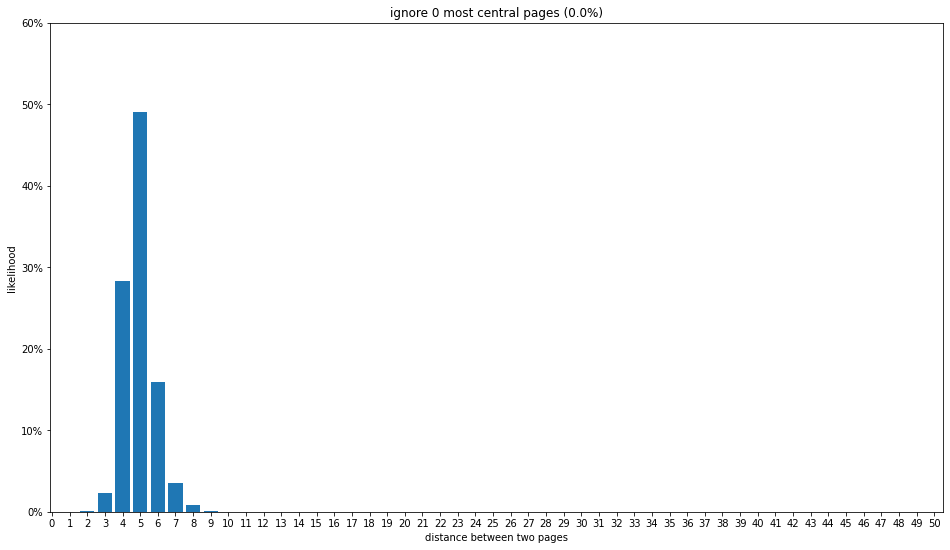

In [82]:
fig, ax = plt.subplots(figsize=(16,9))
bars = ax.bar(ind, np.zeros(ind.size))

ax.set_xlabel('distance between two pages')
ax.set_ylabel('likelihood')
ax.set_xticks(ind)
ax.set_xlim(-.1,50.5)
ax.set_ylim(0,.6)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.grid(False,axis='x')

def update(i):
    n = number_excluded[i]
    for j,b in enumerate(bars):
        b.set_height(distributions[n][j])
    ax.set_title(f"ignore {n} most central pages ({n/lc_graph.num_vertices():.3}%)")

ani = FuncAnimation(fig, update, frames=range(len(number_excluded)), interval=250, repeat_delay=3000)

ani.save('removing_central_pages.mp4')

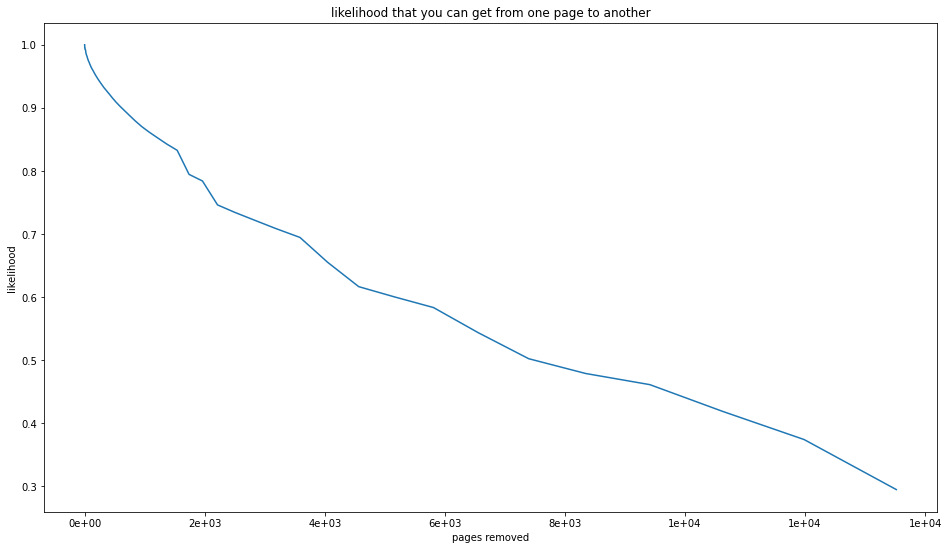

In [51]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(number_excluded,[np.sum(distributions[p]) for p in number_excluded])
ax.set_title('likelihood that you can get from one page to another')
ax.set_xlabel('pages removed')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0}'.format(x/100)))

ax.set_ylabel('likelihood')
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0}'.format(y)))

plt.show()

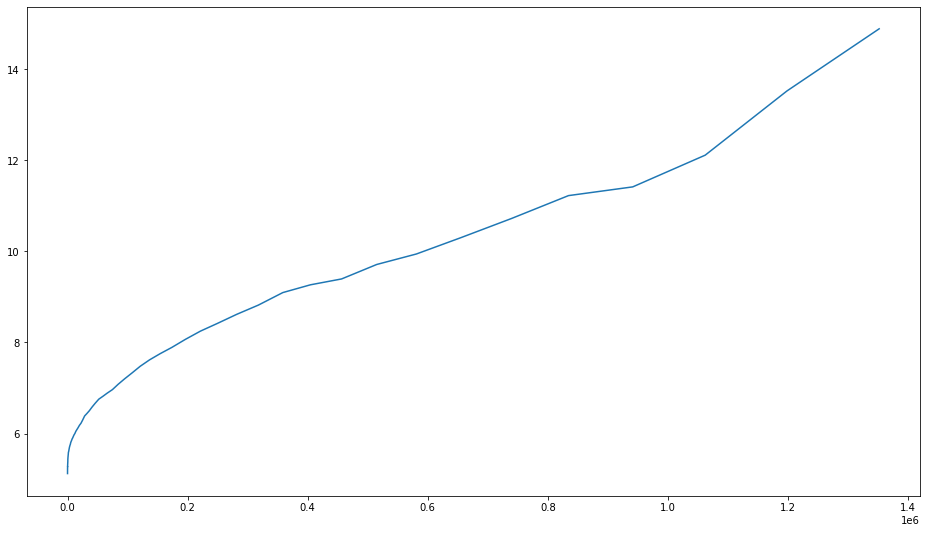

In [52]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(number_excluded, [np.dot(distributions[p],ind)/np.sum(distributions[p]) for p in number_excluded])

plt.show()

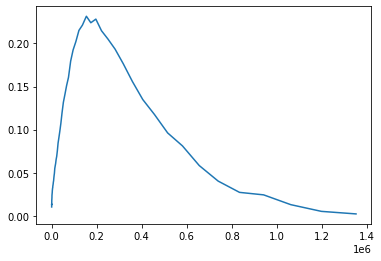

In [60]:
d = 8
plt.plot(number_excluded, [distributions[n][d] for n in number_excluded])

In [64]:
d = 5
[(n, distributions[n][d]) for n in number_excluded]

[(0, 0.5426549024132712),
 (1, 0.5450667847464112),
 (2, 0.5467213311453077),
 (3, 0.5474884961006071),
 (5, 0.5475022945340123),
 (6, 0.5475475441911472),
 (8, 0.546752954952183),
 (10, 0.54655307901481),
 (13, 0.54620580063458),
 (15, 0.5465770927267875),
 (18, 0.5446882195073524),
 (22, 0.5442090793856171),
 (25, 0.5427143038883476),
 (30, 0.542605412141701),
 (34, 0.5413252972046133),
 (40, 0.5384141811406398),
 (46, 0.5373188780977853),
 (53, 0.5366851774417721),
 (61, 0.5364507930935184),
 (69, 0.5359012472666117),
 (79, 0.5349211311460967),
 (90, 0.5330678675823765),
 (103, 0.5313641842964459),
 (117, 0.5305151902753835),
 (133, 0.5288841069660475),
 (151, 0.5281078444135),
 (172, 0.5259297629332166),
 (195, 0.5252977059262094),
 (221, 0.5234299700329913),
 (250, 0.5209847380615198),
 (283, 0.5178860816459633),
 (320, 0.5160617956142185),
 (362, 0.5123196917040432),
 (410, 0.5091342013115004),
 (464, 0.5042782868706632),
 (524, 0.4809568634180273),
 (592, 0.47588902509260317),
 

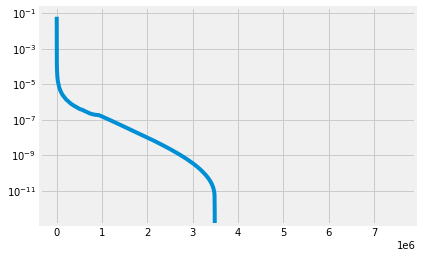

In [201]:
fig,ax = plt.subplots()
ax.plot(np.sort(vb)[::-1])
ax.set_yscale('log')
plt.show()


In [25]:
di, p = gt.pseudo_diameter(lc_graph)

In [28]:
[lc_graph.vp.title[i] for i in p]

['Japan LPGA Championship', '1930 São Paulo FC season']

In [119]:
np.sort(vb)[::-1][lc_graph.num_vertices()//100]

6.75379168520426e-06

In [29]:
di

68.0

In [36]:
for t in tqdm(title_index_map.keys()):
    if '"' in t: print(t, graph.vp.id[title_index_map[t]])

Temperance "Bones" Brennan 11582552
Royce da 5'9" 1273643
Maurice "Moss" Burbidge 16968252
William "Smitty" Smith 22391412
R.E. "Bob" Woodruff Lake 24423053
List of people known as "the Great" 214273
Order "For Merit to the Fatherland" 34562233
Calvin "Fuzz" Jones 38834181
John "Hot Rod" Williams 3450668
Dave "Baby" Cortez 1598086
Charles "Buddy" Rogers 1555606
Mikołaj Krzysztof "the Orphan" Radziwiłł 1319877
"Weird Al" Yankovic 18938265
Arthur "Guitar Boogie" Smith 1631396
"Hello, World!" program 13834
Carl "Alfalfa" Switzer 534430
James "J.T." Taylor 4222804
Robert "Squirrel" Lester 7884763
Dave "Snaker" Ray 1352760
Alphonse "Big Boy" Caprice 8228822
Perri "Pebbles" Reid 2206267
David "Honeyboy" Edwards 936912
William "Bull" Nelson 1822055
Clarence "Gatemouth" Brown 2437473
Evelyn "Champagne" King 2175171
List of books for the "Famous Scots Series" 24240688
"Polish death camp" controversy 3874841
Nymph (Central Figure for "The Three Graces") 31163245
J. R. "Bob" Dobbs 73073
John "Mul

Miejski Stadion Sportowy "KSZO" 13566659
FB "Łucznik" Radom 11541083
List of "Weird Al" Yankovic polka medleys 12798266
Love Theme from "The Godfather" (album) 30602432
Estadio Jesús Martínez "Palillo" 51507455
Al "Jazzbo" Collins 10234232
Institute for Macedonian language "Krste Misirkov" 16925581
Sam Peckinpah's "Salad Days" 2839899
Mauritius "Post Office" stamps 1528819
Allan "Whitey" Snyder 14379103
Jakobus ("James"), Count of Lichtenberg 47045402
Eddie "Lockjaw" Davis 264340
The Rhetoric of Hitler's "Battle" 1864812
Lee "Shot" Williams 16940672
Jim "Dandy" Mangrum 25393121
Enrique "Coco" Vicéns 28396713
Green Line "B" Branch 1902584
Green Line "C" Branch 1902583
Green Line "D" Branch 1902634
Green Line "A" Branch 1903652
Steve "Snapper" Jones 1918471
Clarence "Frogman" Henry 1441938
Stuart "Captain Calamity" Hill 18479449
Leon "Ndugu" Chancler 3657957
The Academy Award-Winning "Call Me Irresponsible" and Other Hit Songs from the Movies 28358705
The Death of "Superman Lives": What 

Jimmy "Duck" Holmes 26710653
Belarusian Women's Party "Nadzieja" 2038995
Agrarian Union "Aleksandar Stamboliyski" 2134561
Civil Union "Roma" 2134562
David "Shark" Fralick 2663015
Evangelical Lutheran Church "Concord" 1707969
H "Two" O 16010926
What's It Gonna Be (H "Two" O song) 15773103
Cyril "Squib" Burton 33401690
All That "Hip Hop" 13221578
Wilfred "Chicken" Smallhorn 5807154
2012 South American Rugby Championship "A" 35894497
2002 South American Rugby Championship "A" 33155108
2015 South American Rugby Championship "A" 46411112
2014 South American Rugby Championship "A" 42568658
2013 South American Rugby Championship "A" 37014698
Eddie "Guitar" Burns 26311302
Ed "Big Ed" Burns 5415963
Leroy "Twist" Casey 13225017
2000 department store "Centrs" bombing 39369898
1st CCNN Division "Dio lo Vuole" 15274823
2nd CCNN Division "Fiamme Nere" 15275539
3rd CCNN Division "Penne Nere" 15275846
William "Stage" Boyd 13969316
Dream "A" Live 22313904
Take the "A" Train 1458754
Parque Luis A. "Wito

Alpini Battalion "Val Brenta" 62525819
3rd Missile Brigade "Aquileia" 39500735
Logistic Regiment "Julia" 11171322
Alpini Battalion "Val Tagliamento" 62526926
Cavalry Brigade "Pozzuolo del Friuli" 21817966
Regiment "Piemonte Cavalleria" (2nd) 62372857
Alpini Battalion "Val Chiese" 62525384
Airmobile Brigade "Friuli" 22178646
Regiment "Nizza Cavalleria" (1st) 62372830
Logistic Regiment "Taurinense" 61275793
Division "Tridentina" 53364199
182nd Armored Infantry Regiment "Garibaldi" 62544684
The Essential "Weird Al" Yankovic 24204138
The "Genius" (novel) 27206158
F. G. "Teddy" Oke Trophy 8278588
C. Alfred "Chief" Anderson 40348617
Jonny "Itch" Fox 42335767
William "Digger" Thomas 17638050
Double "H" Ranch 5767897
Guilty: Liberal "Victims" and Their Assault on America 23420580
The 5'11" Record 11160060
Stephen "tWitch" Boss 28457773
Fiat 500 "Topolino" 615367
Dick "Rocko" Lewis 62098613
The "Hentai" Prince and the Stony Cat. 36627080
1989 VII ACB International Tournament "VI Memorial Héctor

Islamic Organisation "Young Afghanistan" 10418678
Ulysses "Slow Kid" Thompson 49134365
Anthony "Sooty" Jones 5548731
Paul "Wine" Jones 25729560
Medal "For the Development of Virgin Lands" 35569487
Istituto Scolastico Italiano "Giovan Battista Hodierna" 48354655
Linious "Mac" McGee 23719229
President's Day Split 7" 8255837
Optimum "L" filter 2642314
Jeff "Swampy" Marsh 6103139
Claude "Bud" Lewis Carlsbad Desalination Plant 25442428
Medal "10 years of Astana" 54643425
Chicago "L" rolling stock 9236533
Curley "Boo" Johnson 30037143
Fred "Cappy" Capossela Stakes 4853815
Arthur "Artie" Nielsen 31691005
Changuinola "Capitán Manuel Niño" International Airport 27620002
Bocas del Toro "Isla Colón" International Airport 15111501
The Supreme Florence "Flo" Ballard 2656796
Harry "Cherries" Dunn 17984097
Jack "Russer" Russell 2659517
"E" Is for Evidence 16251903
Shenandoah River Raymond R. "Andy" Guest Jr. State Park 17666724
Kevin "Boxer" Moran 49603552
Joseph "Pleasant Gardens" McDowell 699122
Jo

Battery "G", 1st Illinois Light Artillery Regiment 31008078
Battery "D", 2nd Illinois Light Artillery Regiment 28347878
Mass in C major, K. 258 "Piccolomini" 38668852
Mass in C major, K. 257 "Credo" 38663778
Mass in G major, K. 140 "Pastoral" 24149505
Mass in C major, K. 220 "Sparrow" 24638645
Mass in C major, K. 259 "Organ solo" 38637839
Jack "Basher" Williams 32840754
Anthony "Tiny" Biuso 37086223
The Unreleased "D.C. Tapes" 10847871
Lou B. ("Bink") Noll 11795748
Seok-Hyun "Andy" Yun 52996288
Harriet "Hattie" Elizabeth Wilcox 25764734
J. T. "Blondy" Black 20483076
The "Me" Decade and the Third Great Awakening 41815531
Dial "S" for Sonny 25508266
Eric "Red Mouth" Gebhardt 5847170
Bryan "Badger" Goss 22534693
Floyd "Candy" Johnson 17099022
R. M. "Bertie" Smyllie 13926180
Otis "Big Smokey" Smothers 26386230
Polish People's Party "Left" 43523416
Andrew "Boy" Charlton Pool 14933940
Michael "Bear" Taliferro 13848567
Carlos "Carlão" Santos 16803666
"Big" Donnie MacLeod 44296440
Medal "For t

Hannu-Pekka "HP" Parviainen 27416155
Mamady "Wadaba" Kourouma 6727162
Orto Botanico "Pania di Corfino" 16934233
Hiram "Doc" Jones 42536671
W. T. "Dub" Robinson Stadium 38759994
Jazz for "Breakfast at Tiffany's" 35741118
Clarence T. "Curly" Edwinson 24720533
52nd Artillery Regiment "Torino" 62642583
82nd Infantry Regiment "Torino" 62628961
Medal "For the Capture of Vienna" 35001356
William E. "Pinky" Newell 25139973
Abel Head "Shanghai" Pierce 23833187
B. H. "Johnny" Rogers 44210970
National Company "Strategic Infrastructure Projects" 38145576
G-Man Training Target 7" 21431701
Dave "Chico" Ryan 12465851
Arnold "Puggy" Hunter 46872536
The Complete 12"ers Collection Vol. 1 24804767
All of This – The "Live" Rarities 12689525
Selections from the Paramount Picture "Just for You" 48698752
Albanian Coalition "Perspective" 2025972
Giardino Botanico "Loreto Grande" 14920891
National Political Association "Çamëria" 21370389
Tullycraft – True Blue 7" 19922808
Robert "Big Mojo" Elem 55694729
Andrew

JTL-E .500 S&W Magnum 12" 28361420
"How's my driving?" sign 31746200
Noel "Razor" Smith 31772978
NATO Ouvrage "G" 44376710
Medal "For Courage in a Fire" 35587411
Medal "For the Restoration of the Donbass Coal Mines" 35609097
Medal "For the Tapping of the Subsoil and Expansion of the Petrochemical Complex of Western Siberia" 35647113
Medal "For the Restoration of the Black Metallurgy Enterprises of the South" 35620644
Medal "For Transforming the Non-Black Earth of the RSFSR" 35641375
Humphrey "Yankee" Smith 28358639
"Oh Yeah!" Live 28632016
Lasanna "Ace" Harris 52679245
4th Legion Tercio "Alejandro Farnesio" 33685550
"Shariah Police" incident in Wuppertal, Germany (2014) 60007668
Emmanuel "Manny" Mijares 46429293
Academia Preuniversitaria "Perpetuo Socorro" 31618661
And He'd Say, "Oo-La-La! Wee-Wee!" 49625857
Maclean's "Too Asian" controversy 33780265
Southern White Rhino ("Bull") 40193909
Leon F. "Lee" Ellis 40199889
George "Corn" Tassel 33799078
Yoshimatsu : Guitar Works "Tender Toys"

Ensemble "Grenada" 60335266
Wahre und Falsche "Fauen-Emanzipation" 57708827
"Lockkeeper's" House 49673705
Guillermo "Pinky" Mordan 60611613
Ronald "Ron" Jones 49734663
Sculptural composition "Egyptian Pyramid" 57878398
Elizabeth "Betty" Lacey 52577166
The "Frenchman's Garden" Murders 59104614
Robert "Bob" Margeas 63335303
List of "return unwanted" concentration camp prisoners 58119489
The Perils of "Privilege" 54881006
Weather station "Taganrog" 57879323
Walter "Mazinyo" Matitta 54973519
Gordon "Jack" Mohr 59142229
Arthur Leslie "Bud" Smith 61316397
Francisco "Chamuscado" Sánchez 55448507
Biotechnological Lyceum "Radowell" 61075363
Cross "For the Capture of Praga" 58622827
Mai Kuraki Live Project 2018 "Red It be: Kimi Omou Shunkashūtō" 62140043
"Big Boy" Teddy Edwards 55500928
Turbaza "Yunost" 58580069
Turbaza "Katun" 58630792
Earl "Flat" Chase 55862472
Henry "Harry" Charles Pernot House 55748289
Margaret W. "Hap" Brennecke 62008814



In [293]:
f = lc_graph.new_vp('bool',val=False)
f.a[np.argsort(vb)[::-1][:100]] = True
g = gt.GraphView(lc_graph,f)

gt.graph_draw(g)

In [297]:
np.sum(np.unique(f.a))

PropertyArray(1, dtype=uint64)

In [298]:
np.unique(f.a)

PropertyArray([0, 1], dtype=uint8)

In [38]:
np.max(graph.vp.id.a)

PropertyArray(63542850, dtype=int32)

In [50]:
path = '''
13820570
328518
20952
248480
17064
'''.strip().split('\n')
for p in path:
    print(graph.vp.title[id_index_map[int(p)]])

Japan LPGA Championship
Ichihara, Chiba
Mobile, Alabama
Dallas/Fort Worth International Airport
Kangaroo


In [42]:
id_index_map

array([      0,       0,       0, ...,       0,       0, 7044793])